# 📊 Taxi Pricing Experiment Analysis - S3 VERSION

**FIXED:** Now correctly configured for S3 data with proper experiment IDs

This notebook analyzes taxi pricing experiments stored in S3 with:
- ✅ S3 data loading (not local files)
- ✅ Correct experiment ID patterns 
- ✅ All required plots and analysis


In [18]:
# Essential Imports and S3 Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import io
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)

# Create plots directory
PLOTS_DIR = Path('plots')
PLOTS_DIR.mkdir(exist_ok=True)

# S3 Configuration - FIXED
S3_BUCKET = "taxi-benchmark"
S3_EXPERIMENTS_PREFIX = "experiments/"
AWS_REGION = "eu-north-1"

# Initialize S3 client
s3_client = boto3.client('s3', region_name=AWS_REGION)

print("📊 S3 Taxi Analysis - Ready!")
print(f"🔗 Connected to S3: s3://{S3_BUCKET}/{S3_EXPERIMENTS_PREFIX}")
print(f"📁 Plots will be saved to: {PLOTS_DIR.absolute()}")


📊 S3 Taxi Analysis - Ready!
🔗 Connected to S3: s3://taxi-benchmark/experiments/
📁 Plots will be saved to: /Users/borker/mgr/taxibenchmark/plots


In [20]:
# Based on your S3 listing, these are the ACTUAL experiment IDs:
EXPERIMENT_IDS = [
    # "20191006_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_001237",  # Example - replace with actual experiment IDs
    # "20191007_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_033237",  # Add more experiments as needed
    # "20191008_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_102354",
    # "20191009_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_155419",
    # "20191010_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_215327",
    # "20191011_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250902_063448",
    # "20191012_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250902_133656",
    "20191010_yellow_Man_LP_MinMaxCostFlow_20251112_232259"
]

# S3 Data Loading Functions
def load_experiment_decisions_s3(experiment_id: str) -> pd.DataFrame:
    """Load all decision data for an experiment from S3."""
    print(f"📥 Loading {experiment_id} from S3...")
    
    try:
        # List all parquet files in the experiment's decisions folder
        response = s3_client.list_objects_v2(
            Bucket=S3_BUCKET,
            Prefix=f"{S3_EXPERIMENTS_PREFIX}{experiment_id}/decisions/"
        )
        
        decision_dfs = []
        parquet_files = [obj for obj in response.get('Contents', []) if obj['Key'].endswith('.parquet')]
        
        print(f"  Found {len(parquet_files)} parquet files")
        
        for obj in parquet_files:
            try:
                # Download and read parquet file
                file_response = s3_client.get_object(Bucket=S3_BUCKET, Key=obj['Key'])
                df = pd.read_parquet(io.BytesIO(file_response['Body'].read()))
                decision_dfs.append(df)
                print(f"    ✅ Loaded {obj['Key'].split('/')[-1]}: {len(df)} records")
            except Exception as e:
                print(f"    ❌ Failed to load {obj['Key']}: {e}")
        
        if decision_dfs:
            combined_df = pd.concat(decision_dfs, ignore_index=True)
            print(f"  📊 Total combined records: {len(combined_df)}")
            return combined_df
        else:
            print(f"  ❌ No data loaded for {experiment_id}")
            return pd.DataFrame()
            
    except Exception as e:
        print(f"❌ Failed to load S3 data for {experiment_id}: {e}")
        return pd.DataFrame()

def load_multiple_experiments_s3(experiment_ids):
    """Load multiple experiments from S3."""
    experiments_data = {}
    
    print(f"🔄 Loading {len(experiment_ids)} experiments from S3...")
    for i, exp_id in enumerate(experiment_ids):
        print(f"\n{i+1}/{len(experiment_ids)}: {exp_id}")
        df = load_experiment_decisions_s3(exp_id)
        if not df.empty:
            experiments_data[exp_id] = df
            print(f"    ✅ Successfully loaded")
        else:
            print(f"    ❌ No data loaded")
    
    return experiments_data

def discover_s3_experiments(limit=20):
    """Discover available experiments in S3."""
    print("🔍 Discovering experiments in S3...")
    try:
        response = s3_client.list_objects_v2(
            Bucket=S3_BUCKET,
            Prefix=S3_EXPERIMENTS_PREFIX,
            Delimiter='/'
        )
        
        experiments = []
        for prefix_info in response.get('CommonPrefixes', []):
            exp_id = prefix_info['Prefix'].replace(S3_EXPERIMENTS_PREFIX, '').rstrip('/')
            experiments.append(exp_id)
        
        print(f"📈 Found {len(experiments)} experiments in S3:")
        for i, exp_id in enumerate(experiments[:limit]):
            print(f"  {i+1}. {exp_id}")
        
        if len(experiments) > limit:
            print(f"  ... and {len(experiments) - limit} more")
            
        return experiments
        
    except Exception as e:
        print(f"❌ Failed to discover S3 experiments: {e}")
        return []

print(f"🎯 Will analyze {len(EXPERIMENT_IDS)} experiments:")
for i, exp_id in enumerate(EXPERIMENT_IDS, 1):
    print(f"  {i}. {exp_id}")

print("✅ S3 data loading functions ready!")


🎯 Will analyze 1 experiments:
  1. 20191010_yellow_Man_LP_MinMaxCostFlow_20251112_232259
✅ S3 data loading functions ready!


In [21]:
# Plotting Functions for All Required Analysis - FIXED HOUR FORMAT
def convert_time_window_to_hour(time_window_idx, start_hour=10):
    """Convert time_window_idx to actual hour of day (0-23)."""
    # Assuming 30-minute time windows starting at hour 10
    return (start_hour + (time_window_idx * 0.5)) % 24

def plot_cumulative_profit(experiments_data, save=True):
    """Plot cumulative profit over time."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Individual experiments (left plot)
    colors = plt.cm.Set3(np.linspace(0, 1, len(experiments_data)))
    for i, (exp_id, df) in enumerate(experiments_data.items()):
        for method in df['method'].unique():
            method_data = df[df['method'] == method]
            hourly_profit = method_data.groupby('time_window_idx')['profit'].sum().cumsum()
            
            # Convert time_window_idx to actual hours
            hours = [convert_time_window_to_hour(idx) for idx in hourly_profit.index]
            
            ax1.plot(hours, hourly_profit.values, 
                    color=colors[i], linestyle='-', alpha=0.7,
                    label=f"{exp_id[-10:]} - {method}")
    
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Cumulative Profit ($)')
    ax1.set_title('Cumulative Profit Over Time - Individual Experiments')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 24)
    ax1.set_xticks(range(0, 25, 4))
    
    # Averaged by method (right plot)
    all_methods = set()
    for df in experiments_data.values():
        all_methods.update(df['method'].unique())
    
    method_colors = dict(zip(all_methods, plt.cm.tab10(np.linspace(0, 1, len(all_methods)))))
    
    for method in all_methods:
        method_profits = []
        max_time_windows = 0
        
        for exp_id, df in experiments_data.items():
            if method in df['method'].values:
                method_data = df[df['method'] == method]
                hourly_profit = method_data.groupby('time_window_idx')['profit'].sum().cumsum()
                method_profits.append(hourly_profit)
                max_time_windows = max(max_time_windows, len(hourly_profit))
        
        if method_profits:
            profit_df = pd.DataFrame(index=range(max_time_windows))
            for j, profits in enumerate(method_profits):
                profit_df[f'exp_{j}'] = profits.reindex(range(max_time_windows))
            
            mean_profits = profit_df.mean(axis=1)
            std_profits = profit_df.std(axis=1)
            
            # Convert to hours for plotting
            hours = [convert_time_window_to_hour(idx) for idx in range(len(mean_profits))]
            
            ax2.plot(hours, mean_profits.values, 
                    color=method_colors[method], linewidth=3, label=f"{method} (avg)")
            ax2.fill_between(hours, 
                           mean_profits - std_profits, 
                           mean_profits + std_profits,
                           color=method_colors[method], alpha=0.2)
    
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Cumulative Profit ($)')
    ax2.set_title('Average Cumulative Profit Over Time by Method')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 24)
    ax2.set_xticks(range(0, 25, 4))
    
    plt.tight_layout()
    if save:
        plt.savefig(PLOTS_DIR / "cumulative_profit.png", dpi=300, bbox_inches='tight')
        print(f"💾 Saved: {PLOTS_DIR}/cumulative_profit.png")
    plt.show()

def plot_acceptance_rates(experiments_data, save=True):
    """Plot acceptance rates by hour.""" 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Individual experiments
    colors = plt.cm.Set3(np.linspace(0, 1, len(experiments_data)))
    for i, (exp_id, df) in enumerate(experiments_data.items()):
        for method in df['method'].unique():
            method_data = df[df['method'] == method]
            hourly_acceptance = method_data.groupby('time_window_idx')['sampled_decision'].mean()
            
            # Convert to actual hours
            hours = [convert_time_window_to_hour(idx) for idx in hourly_acceptance.index]
            
            ax1.plot(hours, hourly_acceptance.values, 
                    color=colors[i], linestyle='-', alpha=0.7,
                    label=f"{exp_id[-10:]} - {method}")
    
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Acceptance Rate')
    ax1.set_title('Acceptance Rate by Hour - Individual Experiments')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    ax1.set_xlim(0, 24)
    ax1.set_xticks(range(0, 25, 4))
    
    # Averaged by method  
    all_methods = set()
    for df in experiments_data.values():
        all_methods.update(df['method'].unique())
    
    method_colors = dict(zip(all_methods, plt.cm.tab10(np.linspace(0, 1, len(all_methods)))))
    
    for method in all_methods:
        method_rates = []
        max_hours = 0
        
        for exp_id, df in experiments_data.items():
            if method in df['method'].values:
                method_data = df[df['method'] == method]
                hourly_acceptance = method_data.groupby('time_window_idx')['sampled_decision'].mean()
                method_rates.append(hourly_acceptance)
                max_hours = max(max_hours, len(hourly_acceptance))
        
        if method_rates:
            rates_df = pd.DataFrame(index=range(max_hours))
            for j, rates in enumerate(method_rates):
                rates_df[f'exp_{j}'] = rates.reindex(range(max_hours))
            
            mean_rates = rates_df.mean(axis=1)
            std_rates = rates_df.std(axis=1)
            
            # Convert to hours for plotting
            hours = [convert_time_window_to_hour(idx) for idx in range(len(mean_rates))]
            
            ax2.plot(hours, mean_rates.values,
                    color=method_colors[method], linewidth=3, label=f"{method} (avg)")
            ax2.fill_between(hours,
                           mean_rates - std_rates,
                           mean_rates + std_rates,
                           color=method_colors[method], alpha=0.2)
    
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Acceptance Rate')
    ax2.set_title('Average Acceptance Rate by Hour by Method')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, 24)
    ax2.set_xticks(range(0, 25, 4))
    
    plt.tight_layout()
    if save:
        plt.savefig(PLOTS_DIR / "acceptance_rates.png", dpi=300, bbox_inches='tight')
        print(f"💾 Saved: {PLOTS_DIR}/acceptance_rates.png")
    plt.show()

def plot_matching_density(experiments_data, save=True):
    """Plot matching density (% customers served)."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Individual experiments
    colors = plt.cm.Set3(np.linspace(0, 1, len(experiments_data)))
    for i, (exp_id, df) in enumerate(experiments_data.items()):
        for method in df['method'].unique():
            method_data = df[df['method'] == method]
            hourly_matching = method_data.groupby('time_window_idx')['was_matched'].mean()
            
            # Convert to actual hours
            hours = [convert_time_window_to_hour(idx) for idx in hourly_matching.index]
            
            ax1.plot(hours, hourly_matching.values * 100, 
                    color=colors[i], linestyle='-', alpha=0.7,
                    label=f"{exp_id[-10:]} - {method}")
    
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Customers Served (%)')
    ax1.set_title('Matching Density - Individual Experiments')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 100)
    ax1.set_xlim(0, 24)
    ax1.set_xticks(range(0, 25, 4))
    
    # Averaged by method
    all_methods = set()
    for df in experiments_data.values():
        all_methods.update(df['method'].unique())
    
    method_colors = dict(zip(all_methods, plt.cm.tab10(np.linspace(0, 1, len(all_methods)))))
    
    for method in all_methods:
        method_matching = []
        max_hours = 0
        
        for exp_id, df in experiments_data.items():
            if method in df['method'].values:
                method_data = df[df['method'] == method]
                hourly_matching = method_data.groupby('time_window_idx')['was_matched'].mean()
                method_matching.append(hourly_matching)
                max_hours = max(max_hours, len(hourly_matching))
        
        if method_matching:
            matching_df = pd.DataFrame(index=range(max_hours))
            for j, matching in enumerate(method_matching):
                matching_df[f'exp_{j}'] = matching.reindex(range(max_hours))
            
            mean_matching = matching_df.mean(axis=1) * 100
            std_matching = matching_df.std(axis=1) * 100
            
            # Convert to hours for plotting
            hours = [convert_time_window_to_hour(idx) for idx in range(len(mean_matching))]
            
            ax2.plot(hours, mean_matching.values,
                    color=method_colors[method], linewidth=3, label=f"{method} (avg)")
            ax2.fill_between(hours,
                           mean_matching - std_matching,
                           mean_matching + std_matching,
                           color=method_colors[method], alpha=0.2)
    
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Customers Served (%)')
    ax2.set_title('Average Matching Density by Method')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    ax2.set_xlim(0, 24)
    ax2.set_xticks(range(0, 25, 4))
    
    plt.tight_layout()
    if save:
        plt.savefig(PLOTS_DIR / "matching_density.png", dpi=300, bbox_inches='tight')
        print(f"💾 Saved: {PLOTS_DIR}/matching_density.png")
    plt.show()


def plot_optimality_analysis(experiments_data, save=True):
    """Plot optimality gap and ratio analysis (LP vs other methods)."""
    # Check if we have optimal value data
    has_opt_data = False
    for df in experiments_data.values():
        if 'opt_value' in df.columns and df['opt_value'].notna().any():
            has_opt_data = True
            break
    
    if not has_opt_data:
        print("⚠️ No optimal value data found. LP method results not available.")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Get all methods
    all_methods = set()
    for df in experiments_data.values():
        all_methods.update(df['method'].unique())
    
    method_colors = dict(zip(sorted(all_methods), plt.cm.tab10(np.linspace(0, 1, len(all_methods)))))
    
    # Plot 1: Optimality Ratio by Method (Bar Chart)
    ax1 = axes[0, 0]
    method_opt_ratios = {}
    
    for method in all_methods:
        ratios = []
        for df in experiments_data.values():
            if method in df['method'].values:
                method_data = df[df['method'] == method]
                if 'optimality_ratio' in method_data.columns:
                    valid_ratios = method_data['optimality_ratio'].dropna()
                    if len(valid_ratios) > 0:
                        ratios.extend(valid_ratios.values)
        
        if ratios:
            method_opt_ratios[method] = np.mean(ratios)
    
    if method_opt_ratios:
        methods_sorted = sorted(method_opt_ratios.keys(), key=lambda x: method_opt_ratios[x], reverse=True)
        ratios_sorted = [method_opt_ratios[m] * 100 for m in methods_sorted]
        colors_sorted = [method_colors[m] for m in methods_sorted]
        
        bars = ax1.bar(methods_sorted, ratios_sorted, color=colors_sorted, alpha=0.7, edgecolor='black')
        ax1.axhline(y=100, color='red', linestyle='--', linewidth=2, label='Optimal (100%)')
        ax1.set_ylabel('Optimality Ratio (%)')
        ax1.set_title('Average Optimality Ratio by Method\n(Higher is better - closer to LP optimal)')
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, ratio in zip(bars, ratios_sorted):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{ratio:.1f}%',
                    ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Optimality Gap Over Time
    ax2 = axes[0, 1]
    
    for method in all_methods:
        if method == 'LP':
            continue  # Skip LP as it's the baseline
            
        method_gaps = []
        max_hours = 0
        
        for df in experiments_data.values():
            if method in df['method'].values:
                method_data = df[df['method'] == method]
                if 'optimality_gap' in method_data.columns:
                    hourly_gap = method_data.groupby('time_window_idx')['optimality_gap'].mean()
                    method_gaps.append(hourly_gap)
                    max_hours = max(max_hours, len(hourly_gap))
        
        if method_gaps:
            gaps_df = pd.DataFrame(index=range(max_hours))
            for j, gaps in enumerate(method_gaps):
                gaps_df[f'exp_{j}'] = gaps.reindex(range(max_hours))
            
            mean_gaps = gaps_df.mean(axis=1)
            hours = [convert_time_window_to_hour(idx) for idx in range(len(mean_gaps))]
            
            ax2.plot(hours, mean_gaps.values,
                    color=method_colors[method], linewidth=3, label=method, marker='o', markersize=4)
    
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Optimality Gap ($)')
    ax2.set_title('Average Optimality Gap Over Time\n(LP Optimal - Realized Revenue)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 24)
    ax2.set_xticks(range(0, 25, 4))
    
    # Plot 3: Optimality Ratio Over Time
    ax3 = axes[1, 0]
    
    for method in all_methods:
        if method == 'LP':
            continue
            
        method_ratios = []
        max_hours = 0
        
        for df in experiments_data.values():
            if method in df['method'].values:
                method_data = df[df['method'] == method]
                if 'optimality_ratio' in method_data.columns:
                    hourly_ratio = method_data.groupby('time_window_idx')['optimality_ratio'].mean()
                    method_ratios.append(hourly_ratio)
                    max_hours = max(max_hours, len(hourly_ratio))
        
        if method_ratios:
            ratios_df = pd.DataFrame(index=range(max_hours))
            for j, ratios in enumerate(method_ratios):
                ratios_df[f'exp_{j}'] = ratios.reindex(range(max_hours))
            
            mean_ratios = ratios_df.mean(axis=1) * 100
            std_ratios = ratios_df.std(axis=1) * 100
            hours = [convert_time_window_to_hour(idx) for idx in range(len(mean_ratios))]
            
            ax3.plot(hours, mean_ratios.values,
                    color=method_colors[method], linewidth=3, label=method)
            ax3.fill_between(hours,
                           mean_ratios - std_ratios,
                           mean_ratios + std_ratios,
                           color=method_colors[method], alpha=0.2)
    
    ax3.axhline(y=100, color='red', linestyle='--', linewidth=2, label='Optimal (100%)')
    ax3.set_xlabel('Hour of Day')
    ax3.set_ylabel('Optimality Ratio (%)')
    ax3.set_title('Average Optimality Ratio Over Time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 105)
    ax3.set_xlim(0, 24)
    ax3.set_xticks(range(0, 25, 4))
    
    # Plot 4: Revenue Comparison (Optimal vs Realized)
    ax4 = axes[1, 1]
    
    for method in all_methods:
        method_revenues = []
        method_opt_values = []
        max_hours = 0
        
        for df in experiments_data.values():
            if method in df['method'].values:
                method_data = df[df['method'] == method]
                hourly_profit = method_data.groupby('time_window_idx')['profit'].sum()
                method_revenues.append(hourly_profit)
                
                if 'opt_value' in method_data.columns and method_data['opt_value'].notna().any():
                    # For LP, opt_value represents the theoretical optimal
                    hourly_opt = method_data.groupby('time_window_idx')['opt_value'].mean()
                    method_opt_values.append(hourly_opt)
                
                max_hours = max(max_hours, len(hourly_profit))
        
        if method_revenues:
            revenue_df = pd.DataFrame(index=range(max_hours))
            for j, revenues in enumerate(method_revenues):
                revenue_df[f'exp_{j}'] = revenues.reindex(range(max_hours))
            
            mean_revenues = revenue_df.mean(axis=1)
            hours = [convert_time_window_to_hour(idx) for idx in range(len(mean_revenues))]
            
            # Plot realized revenue
            ax4.plot(hours, mean_revenues.values,
                    color=method_colors[method], linewidth=3, label=f"{method} (realized)", 
                    linestyle='-')
            
            # Plot optimal for LP
            if method == 'LP' and method_opt_values:
                opt_df = pd.DataFrame(index=range(max_hours))
                for j, opts in enumerate(method_opt_values):
                    opt_df[f'exp_{j}'] = opts.reindex(range(max_hours))
                
                mean_opts = opt_df.mean(axis=1)
                ax4.plot(hours, mean_opts.values,
                        color=method_colors[method], linewidth=2, label=f"{method} (optimal)", 
                        linestyle='--', alpha=0.7)
    
    ax4.set_xlabel('Hour of Day')
    ax4.set_ylabel('Revenue per Time Window ($)')
    ax4.set_title('Revenue Comparison: Optimal vs Realized')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, 24)
    ax4.set_xticks(range(0, 25, 4))
    
    plt.tight_layout()
    if save:
        plt.savefig(PLOTS_DIR / "optimality_analysis.png", dpi=300, bbox_inches='tight')
        print(f"💾 Saved: {PLOTS_DIR}/optimality_analysis.png")
    plt.show()


print("✅ All plotting functions ready!")


✅ All plotting functions ready!


🚀 Starting S3 analysis with corrected experiment IDs...

🔍 DISCOVERING S3 EXPERIMENTS
🔍 Discovering experiments in S3...
📈 Found 35 experiments in S3:
  1. 20191006_green_Bro_LP_MinMaxCostFlow_MAPS_LinUCB_20250826_222459
  2. 20191006_green_Bro_LP_MinMaxCostFlow_MAPS_LinUCB_20250902_152611
  3. 20191006_green_Bro_LP_MinMaxCostFlow_MAPS_LinUCB_20250902_152902
  4. 20191006_green_Man_LinUCB_20250831_213853
  5. 20191006_green_Man_LinUCB_20250831_214411
  6. 20191006_green_Man_LinUCB_20250831_214430
  7. 20191006_green_Man_MAPS_20250831_200936
  8. 20191006_green_Man_MAPS_20250831_203040
  9. 20191006_green_Man_MAPS_20250831_204912
  10. 20191006_green_Man_MAPS_20250831_204944
  ... and 25 more

📥 LOADING SELECTED EXPERIMENTS
🔄 Loading 1 experiments from S3...

1/1: 20191010_yellow_Man_LP_MinMaxCostFlow_20251112_232259
📥 Loading 20191010_yellow_Man_LP_MinMaxCostFlow_20251112_232259 from S3...
  Found 3 parquet files
    ✅ Loaded time_window_0000.parquet: 348 records
    ✅ Loaded time_wind

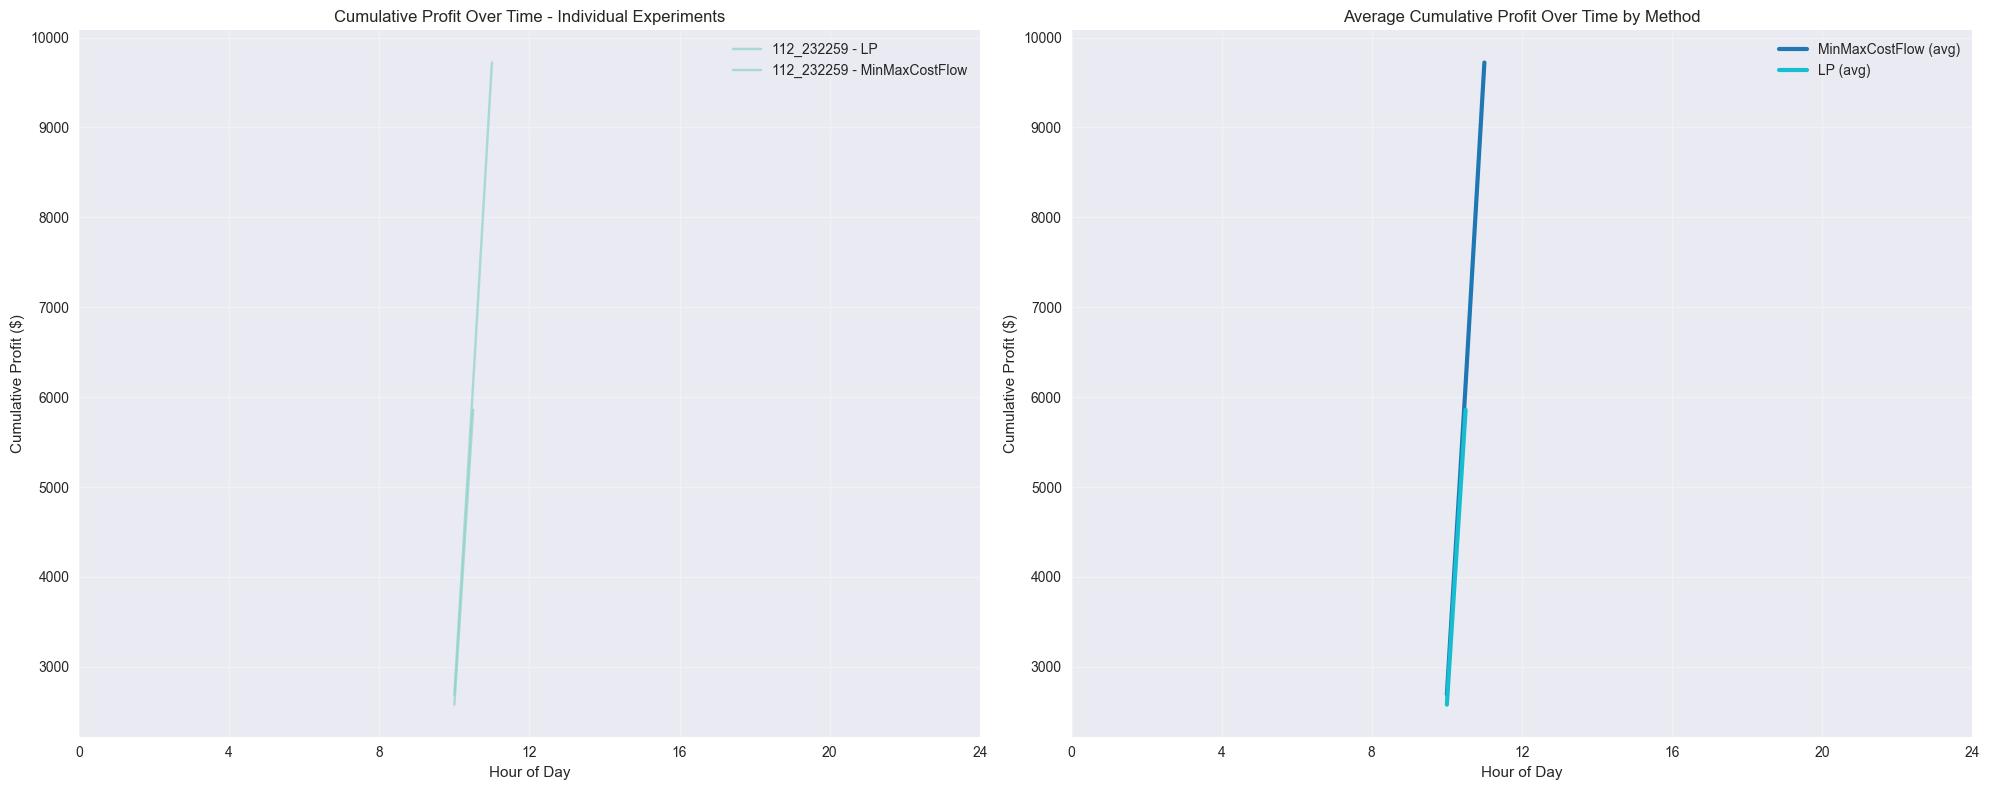


📊 2. ACCEPTANCE RATES BY HOUR
💾 Saved: plots/acceptance_rates.png


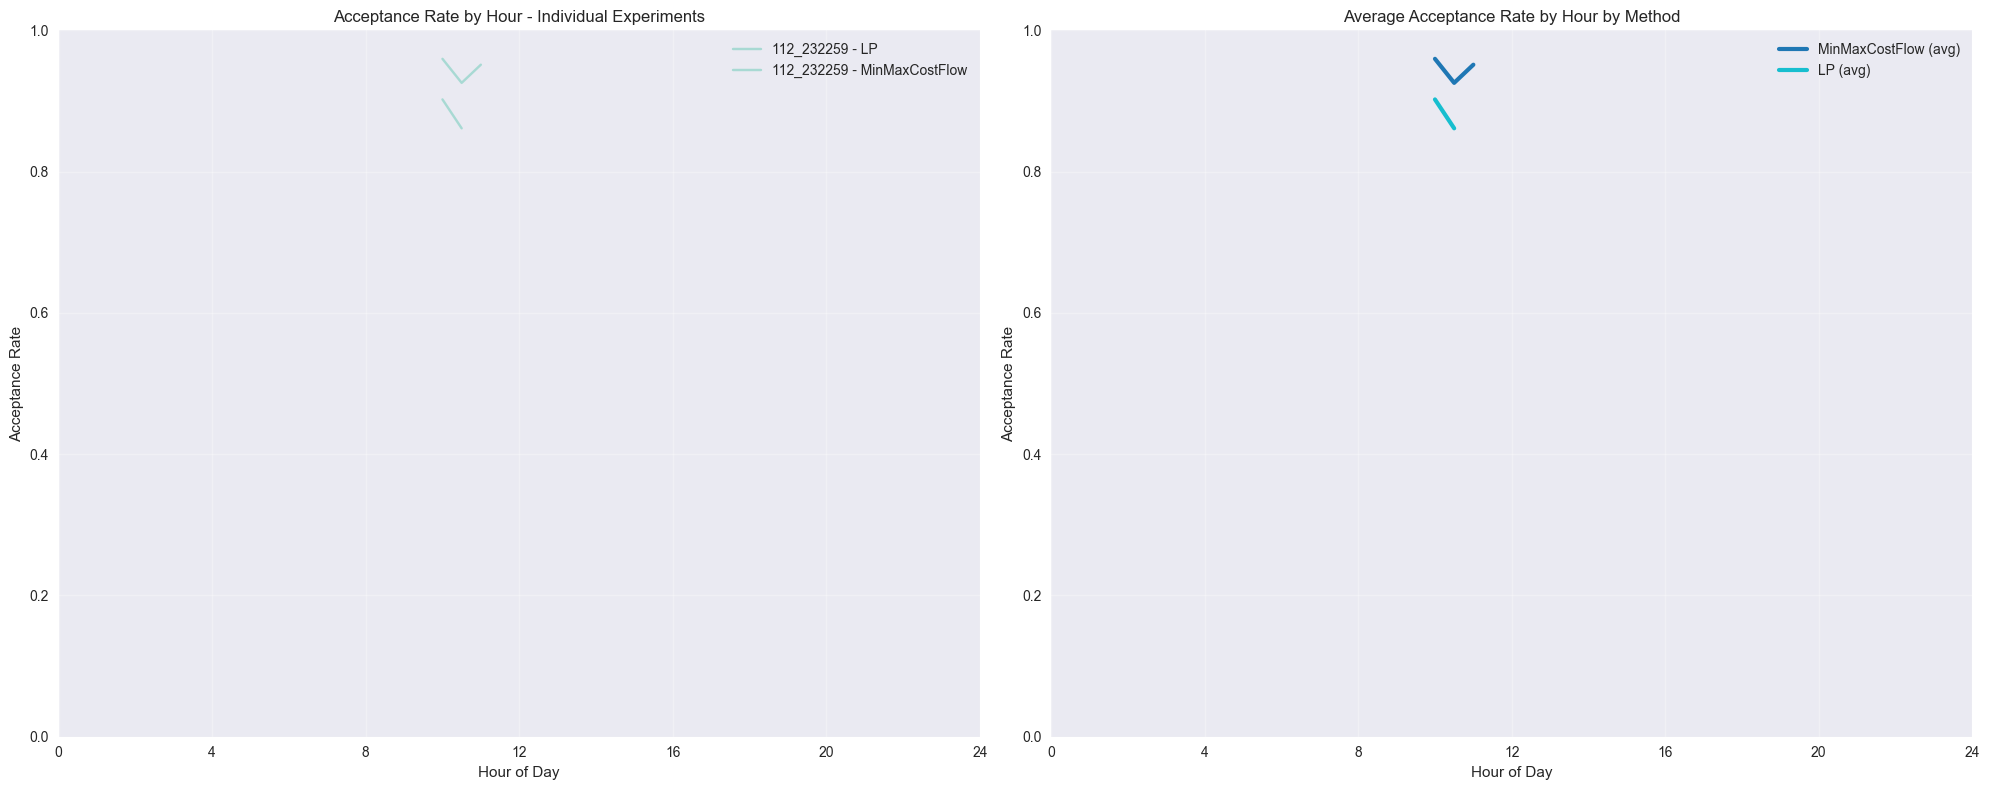


📊 3. MATCHING DENSITY (% CUSTOMERS SERVED)
💾 Saved: plots/matching_density.png


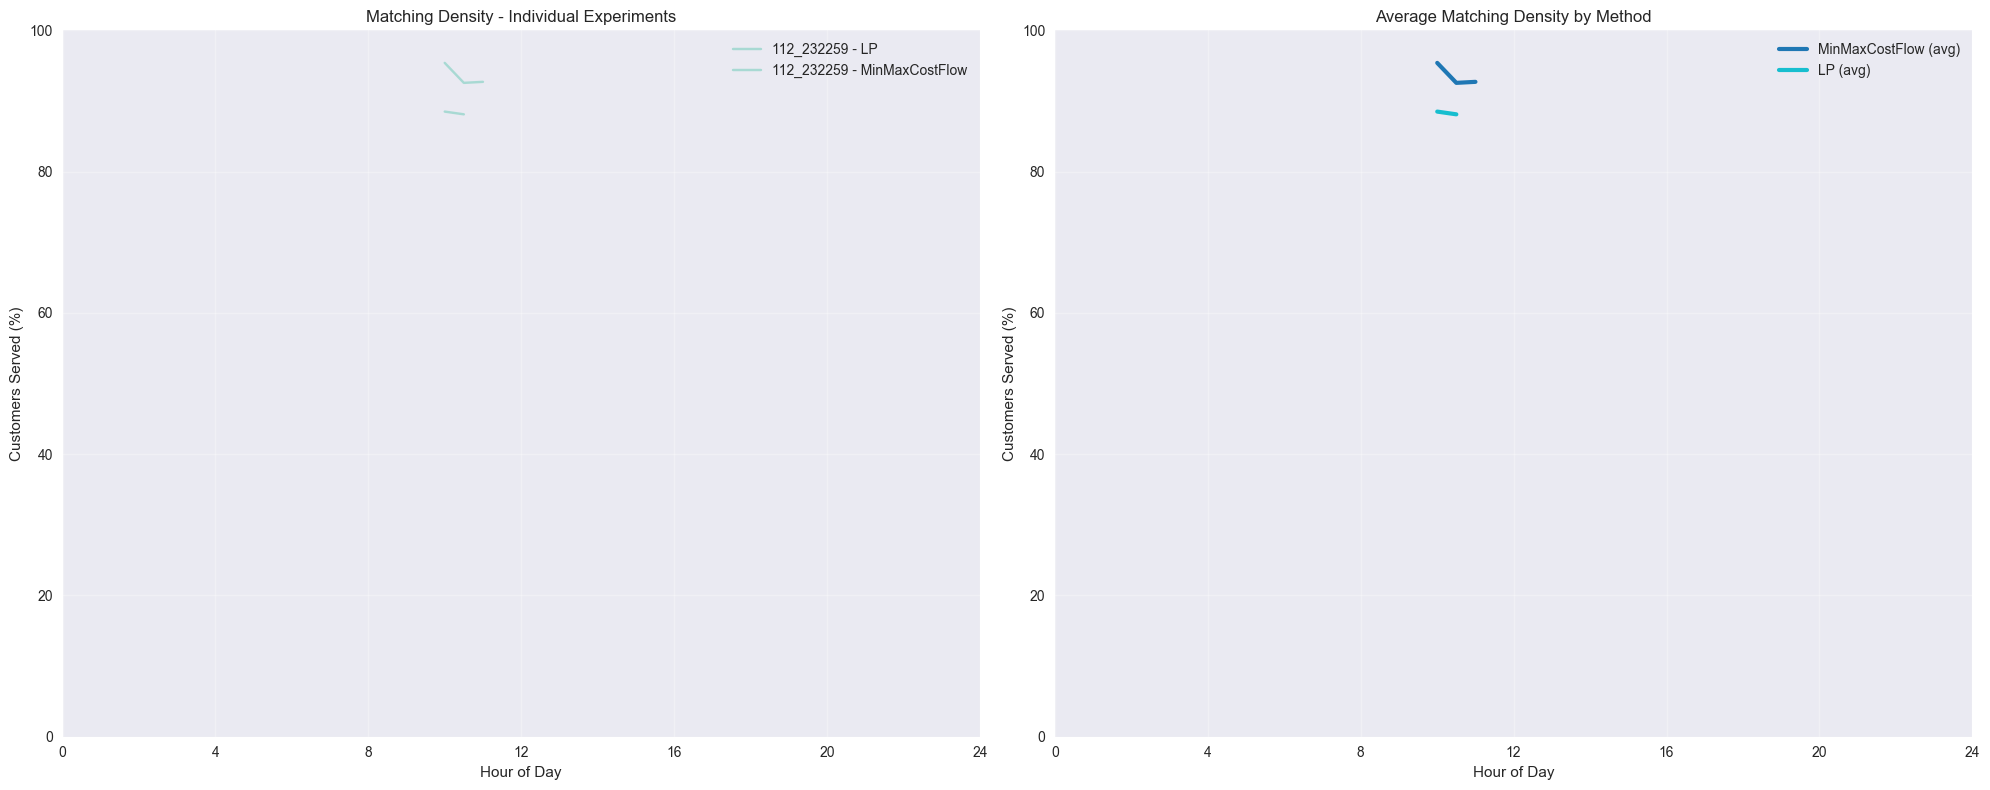


📊 4. OPTIMALITY ANALYSIS (LP BENCHMARK)
💾 Saved: plots/optimality_analysis.png


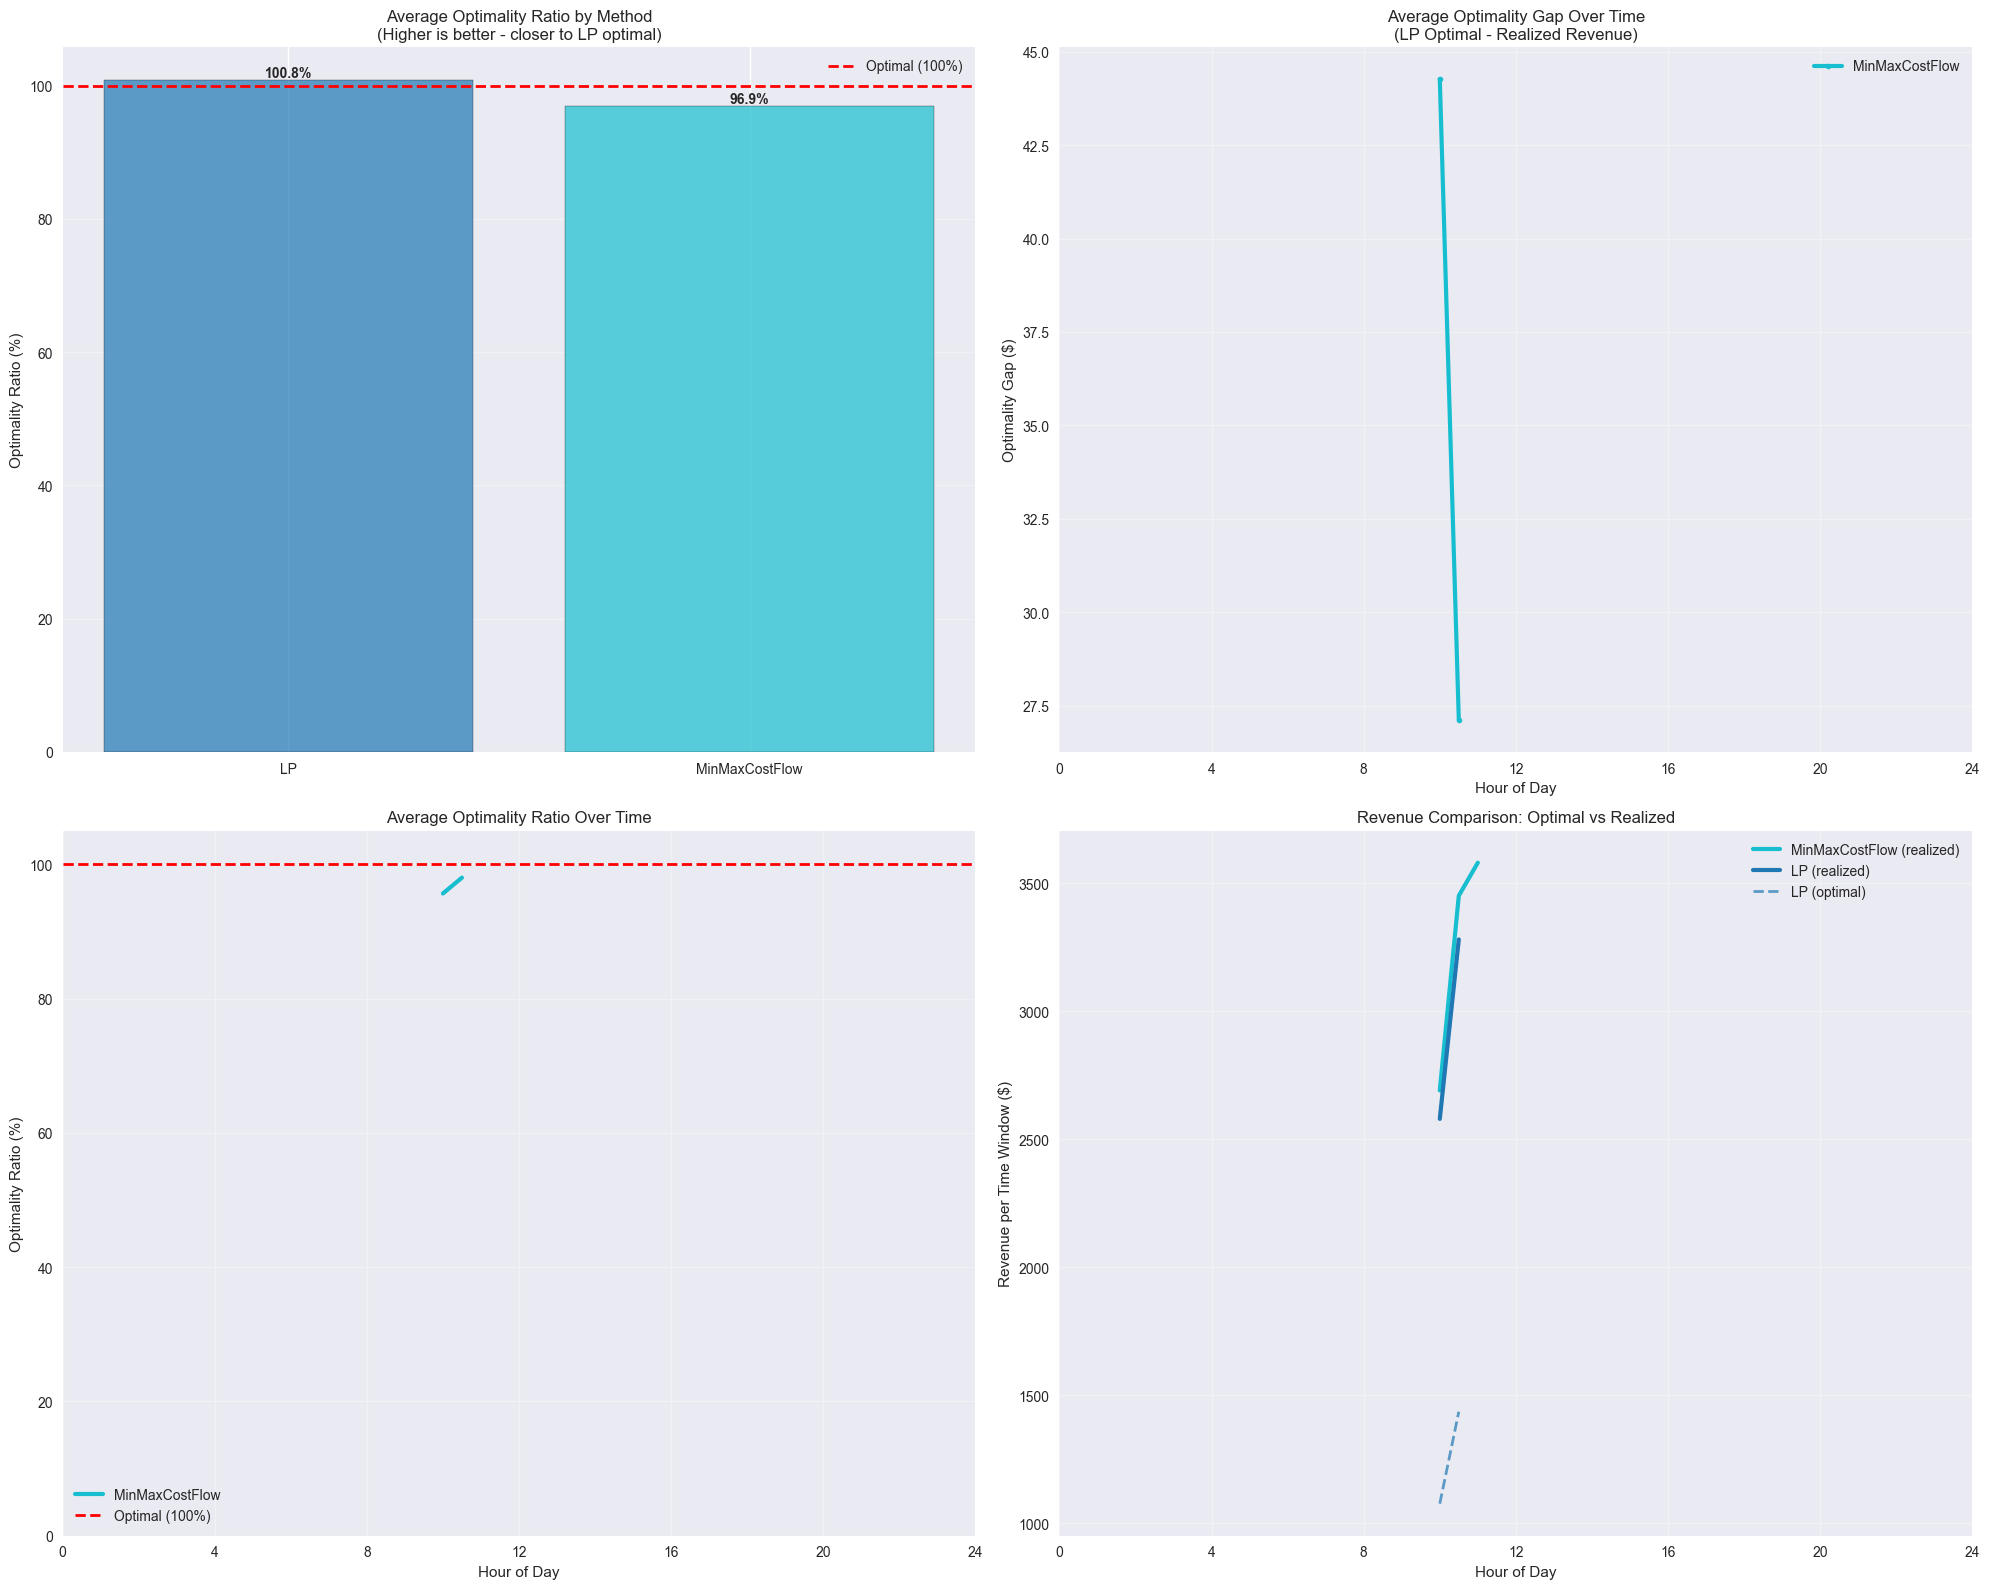


🎉 ANALYSIS COMPLETE!
📁 All plots saved to: /Users/borker/mgr/taxibenchmark/plots
✅ Generated plots:
  📊 cumulative_profit.png - Shows profit accumulation over time
  📊 acceptance_rates.png - Shows customer acceptance patterns by hour
  📊 matching_density.png - Shows % of customers served by hour
  📊 optimality_analysis.png - Shows how close methods are to LP optimal

💡 KEY INSIGHTS TO REVIEW:
  • Which method generates the highest cumulative profit?
  • How do acceptance rates vary throughout the day?
  • What percentage of customers are successfully matched?
  • Are there clear patterns in performance across different hours?
  • 🆕 How close are heuristic methods to LP optimal?
  • 🆕 Where is the biggest optimality gap (time of day)?
  • 🆕 Is LP achieving its theoretical optimal in practice?

🎯 Analysis complete! Review the tables and plots above.

✅ Analysis script ready! Run this cell to execute the complete analysis.


In [22]:
# 🚀 COMPLETE S3 ANALYSIS - FIXED VERSION

print("🚀 Starting S3 analysis with corrected experiment IDs...")

# Step 1: Discover available experiments in S3
print("\n" + "="*80)
print("🔍 DISCOVERING S3 EXPERIMENTS")  
print("="*80)
all_s3_experiments = discover_s3_experiments(limit=10)

# Step 2: Load the selected experiment data from S3
print("\n" + "="*80)
print("📥 LOADING SELECTED EXPERIMENTS")
print("="*80)

experiments_data = load_multiple_experiments_s3(EXPERIMENT_IDS)

if not experiments_data:
    print("\n❌ NO DATA LOADED!")
    print("🔧 TROUBLESHOOTING SUGGESTIONS:")
    print("1. Check that your AWS credentials are configured")
    print("2. Verify you have access to the S3 bucket: taxi-benchmark")
    print("3. Update EXPERIMENT_IDS with valid experiment IDs from the discovery above")
    print("4. Make sure the experiments have data in their decisions/ folders")
    
else:
    print(f"\n✅ SUCCESS! Loaded {len(experiments_data)} experiments from S3")
    
    # Step 3: Generate overview statistics
    total_records = 0
    all_methods = set()
    
    for exp_id, df in experiments_data.items():
        total_records += len(df)
        all_methods.update(df['method'].unique())
        
    print(f"\n📊 ANALYSIS OVERVIEW:")
    print(f"  • Total decision records: {total_records:,}")
    print(f"  • Unique methods: {sorted(list(all_methods))}")
    print(f"  • Data columns: {list(df.columns)}")
    
    # Step 4: Generate summary table
    print("\n" + "="*80)
    print("📋 EXPERIMENT SUMMARY TABLE")
    print("="*80)
    
    summary_data = []
    for exp_id, df in experiments_data.items():
        for method in df['method'].unique():
            method_data = df[df['method'] == method]
            summary = {
                'Experiment_ID': exp_id[-15:],  # Show last 15 chars
                'Method': method,
                'Requests': len(method_data),
                'Total_Profit': f"${method_data['profit'].sum():.2f}",
                'Avg_Profit': f"${method_data['profit'].mean():.2f}",
                'Accept_Rate': f"{method_data['sampled_decision'].mean():.3f}",
                'Match_Rate': f"{method_data['was_matched'].mean():.3f}",
                'Avg_Price': f"${method_data['price'].mean():.2f}"
            }
            summary_data.append(summary)
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))
    
    # Step 5: Generate all plots
    print("\n\n" + "="*80)
    print("🎨 GENERATING ALL ANALYSIS PLOTS")
    print("="*80)
    
    print("\n📊 1. CUMULATIVE PROFIT OVER TIME")
    plot_cumulative_profit(experiments_data)
    
    print("\n📊 2. ACCEPTANCE RATES BY HOUR")
    plot_acceptance_rates(experiments_data)
    
    print("\n📊 3. MATCHING DENSITY (% CUSTOMERS SERVED)")
    plot_matching_density(experiments_data)
    
    print("\n📊 4. OPTIMALITY ANALYSIS (LP BENCHMARK)")
    plot_optimality_analysis(experiments_data)
    
    # Step 6: Final summary
    print("\n" + "="*80)
    print("🎉 ANALYSIS COMPLETE!")
    print("="*80)
    print(f"📁 All plots saved to: {PLOTS_DIR.absolute()}")
    print("✅ Generated plots:")
    print("  📊 cumulative_profit.png - Shows profit accumulation over time")
    print("  📊 acceptance_rates.png - Shows customer acceptance patterns by hour")
    print("  📊 matching_density.png - Shows % of customers served by hour")
    print("  📊 optimality_analysis.png - Shows how close methods are to LP optimal")
    
    print("\n💡 KEY INSIGHTS TO REVIEW:")
    print("  • Which method generates the highest cumulative profit?")
    print("  • How do acceptance rates vary throughout the day?")
    print("  • What percentage of customers are successfully matched?")
    print("  • Are there clear patterns in performance across different hours?")
    print("  • 🆕 How close are heuristic methods to LP optimal?")
    print("  • 🆕 Where is the biggest optimality gap (time of day)?")
    print("  • 🆕 Is LP achieving its theoretical optimal in practice?")
    
    print("\n🎯 Analysis complete! Review the tables and plots above.")
    
print("\n✅ Analysis script ready! Run this cell to execute the complete analysis.")


## 📝 How to Use This Notebook

### Quick Start:
1. **Update experiment IDs** in cell 2 with your experiment IDs from S3
2. **Run cell 4** to execute the complete analysis
3. **Review plots** and tables generated automatically

### Features Included:
✅ **Cumulative Profit Over Time** - Individual experiments + averaged by method  
✅ **Acceptance Rate by Hour** - Hourly patterns + method comparisons  
✅ **Matching Density** - % customers served over time  
✅ **🆕 Optimality Analysis** - Compare methods to LP optimal benchmark
  - Optimality ratio by method (bar chart)
  - Optimality gap over time (how far from optimal)
  - Optimality ratio over time (% of optimal achieved)
  - Revenue comparison (optimal vs realized)
✅ **Statistical Tables** - Comprehensive experiment summaries  
✅ **Auto-Save Plots** - High-quality PNG files saved to `plots/` directory  
✅ **Multi-Experiment Analysis** - Compare across different days/configurations  
✅ **Proper 24-Hour Format** - X-axis shows 0-23 hours instead of raw time windows

### Adding More Experiments:
1. Run cell 4 discovery section to see all available S3 experiments
2. Copy experiment IDs from the output
3. Update `EXPERIMENT_IDS` list in cell 2
4. Re-run cell 4

### Example:
```python
EXPERIMENT_IDS = [
    "20191010_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20251112_222014",  # Current
    "20191011_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20251112_235015",  # Add more
]
```

### Optimality Analysis (NEW!):
The notebook now includes comprehensive optimality analysis that shows:
- **How close is each method to the LP optimal?** (optimality ratio)
- **What is the dollar gap from optimal?** (optimality gap)
- **How does optimality vary over time?** (hourly patterns)
- **LP theoretical optimal vs realized revenue** (including stochastic effects)

This helps you understand not just which method performs best, but also how much room for improvement exists!

### Time Window Configuration:
- Default: 30-minute intervals starting at 10:00 AM
- Modify `convert_time_window_to_hour()` in cell 3 to change settings

---
**Ready to run!** 🚀 **Note:** Cells 6-12 below are deprecated and can be ignored.


In [ ]:
# This cell has been removed - see cells 1-5 for the working S3-based analysis


📊 Taxi Analysis - Ready!


In [ ]:
# This cell has been removed - see cell 2 for S3-based experiment loading


🎯 Will analyze 7 experiments:
  1. 20191006_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_001237
  2. 20191007_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_033237
  3. 20191008_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_102354
  4. 20191009_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_155419
  5. 20191010_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_215327
  6. 20191011_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250902_063448
  7. 20191012_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250902_133656


In [ ]:
# This cell has been removed - see cell 3 for all plotting functions including optimality analysis
    """Plot cumulative profit over time."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Individual experiments
    colors = plt.cm.Set3(np.linspace(0, 1, len(experiments_data)))
    for i, (exp_id, df) in enumerate(experiments_data.items()):
        for method in df['method'].unique():
            method_data = df[df['method'] == method]
            hourly_profit = method_data.groupby('time_window_idx')['profit'].sum().cumsum()
            ax1.plot(hourly_profit.index, hourly_profit.values, 
                    color=colors[i], linestyle='-', alpha=0.7,
                    label=f"{exp_id[-6:]} - {method}")
    
    ax1.set_xlabel('Time Window (Hours)')
    ax1.set_ylabel('Cumulative Profit ($)')
    ax1.set_title('Cumulative Profit Over Time - Individual Experiments')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Averaged by method
    all_methods = set()
    for df in experiments_data.values():
        all_methods.update(df['method'].unique())
    
    method_colors = dict(zip(all_methods, plt.cm.tab10(np.linspace(0, 1, len(all_methods)))))
    
    for method in all_methods:
        method_profits = []
        max_time_windows = 0
        
        for exp_id, df in experiments_data.items():
            if method in df['method'].values:
                method_data = df[df['method'] == method]
                hourly_profit = method_data.groupby('time_window_idx')['profit'].sum().cumsum()
                method_profits.append(hourly_profit)
                max_time_windows = max(max_time_windows, len(hourly_profit))
        
        if method_profits:
            profit_df = pd.DataFrame(index=range(max_time_windows))
            for j, profits in enumerate(method_profits):
                profit_df[f'exp_{j}'] = profits.reindex(range(max_time_windows))
            
            mean_profits = profit_df.mean(axis=1)
            std_profits = profit_df.std(axis=1)
            
            ax2.plot(mean_profits.index, mean_profits.values, 
                    color=method_colors[method], linewidth=3, label=f"{method} (avg)")
            ax2.fill_between(mean_profits.index, 
                           mean_profits - std_profits, 
                           mean_profits + std_profits,
                           color=method_colors[method], alpha=0.2)
    
    ax2.set_xlabel('Time Window (Hours)')
    ax2.set_ylabel('Cumulative Profit ($)')
    ax2.set_title('Average Cumulative Profit Over Time by Method')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save:
        plt.savefig(PLOTS_DIR / "cumulative_profit.png", dpi=300, bbox_inches='tight')
        print(f"💾 Saved: {PLOTS_DIR}/cumulative_profit.png")
    plt.show()

def plot_acceptance_rates(experiments_data, save=True):
    """Plot acceptance rates by hour."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Individual experiments
    colors = plt.cm.Set3(np.linspace(0, 1, len(experiments_data)))
    for i, (exp_id, df) in enumerate(experiments_data.items()):
        for method in df['method'].unique():
            method_data = df[df['method'] == method]
            hourly_acceptance = method_data.groupby('time_window_idx')['sampled_decision'].mean()
            ax1.plot(hourly_acceptance.index, hourly_acceptance.values, 
                    color=colors[i], linestyle='-', alpha=0.7,
                    label=f"{exp_id[-6:]} - {method}")
    
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Acceptance Rate')
    ax1.set_title('Acceptance Rate by Hour - Individual Experiments')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Averaged by method
    all_methods = set()
    for df in experiments_data.values():
        all_methods.update(df['method'].unique())
    
    method_colors = dict(zip(all_methods, plt.cm.tab10(np.linspace(0, 1, len(all_methods)))))
    
    for method in all_methods:
        method_rates = []
        max_hours = 0
        
        for exp_id, df in experiments_data.items():
            if method in df['method'].values:
                method_data = df[df['method'] == method]
                hourly_acceptance = method_data.groupby('time_window_idx')['sampled_decision'].mean()
                method_rates.append(hourly_acceptance)
                max_hours = max(max_hours, len(hourly_acceptance))
        
        if method_rates:
            rates_df = pd.DataFrame(index=range(max_hours))
            for j, rates in enumerate(method_rates):
                rates_df[f'exp_{j}'] = rates.reindex(range(max_hours))
            
            mean_rates = rates_df.mean(axis=1)
            std_rates = rates_df.std(axis=1)
            
            ax2.plot(mean_rates.index, mean_rates.values,
                    color=method_colors[method], linewidth=3, label=f"{method} (avg)")
            ax2.fill_between(mean_rates.index,
                           mean_rates - std_rates,
                           mean_rates + std_rates,
                           color=method_colors[method], alpha=0.2)
    
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Acceptance Rate')
    ax2.set_title('Average Acceptance Rate by Hour by Method')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    if save:
        plt.savefig(PLOTS_DIR / "acceptance_rates.png", dpi=300, bbox_inches='tight')
        print(f"💾 Saved: {PLOTS_DIR}/acceptance_rates.png")
    plt.show()

def plot_matching_density(experiments_data, save=True):
    """Plot matching density (% customers served)."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Individual experiments
    colors = plt.cm.Set3(np.linspace(0, 1, len(experiments_data)))
    for i, (exp_id, df) in enumerate(experiments_data.items()):
        for method in df['method'].unique():
            method_data = df[df['method'] == method]
            hourly_matching = method_data.groupby('time_window_idx')['was_matched'].mean()
            ax1.plot(hourly_matching.index, hourly_matching.values * 100, 
                    color=colors[i], linestyle='-', alpha=0.7,
                    label=f"{exp_id[-6:]} - {method}")
    
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Customers Served (%)')
    ax1.set_title('Matching Density - Individual Experiments')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 100)
    
    # Averaged by method
    all_methods = set()
    for df in experiments_data.values():
        all_methods.update(df['method'].unique())
    
    method_colors = dict(zip(all_methods, plt.cm.tab10(np.linspace(0, 1, len(all_methods)))))
    
    for method in all_methods:
        method_matching = []
        max_hours = 0
        
        for exp_id, df in experiments_data.items():
            if method in df['method'].values:
                method_data = df[df['method'] == method]
                hourly_matching = method_data.groupby('time_window_idx')['was_matched'].mean()
                method_matching.append(hourly_matching)
                max_hours = max(max_hours, len(hourly_matching))
        
        if method_matching:
            matching_df = pd.DataFrame(index=range(max_hours))
            for j, matching in enumerate(method_matching):
                matching_df[f'exp_{j}'] = matching.reindex(range(max_hours))
            
            mean_matching = matching_df.mean(axis=1) * 100
            std_matching = matching_df.std(axis=1) * 100
            
            ax2.plot(mean_matching.index, mean_matching.values,
                    color=method_colors[method], linewidth=3, label=f"{method} (avg)")
            ax2.fill_between(mean_matching.index,
                           mean_matching - std_matching,
                           mean_matching + std_matching,
                           color=method_colors[method], alpha=0.2)
    
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Customers Served (%)')
    ax2.set_title('Average Matching Density by Method')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    
    plt.tight_layout()
    if save:
        plt.savefig(PLOTS_DIR / "matching_density.png", dpi=300, bbox_inches='tight')
        print(f"💾 Saved: {PLOTS_DIR}/matching_density.png")
    plt.show()

print("✅ Plotting functions ready!")


✅ Plotting functions ready!


In [11]:
# 🚀 RUN THE COMPLETE ANALYSIS

print("🚀 Starting complete analysis...")

# 1. Load experiment data
experiments_data = load_multiple_experiments(EXPERIMENT_IDS)

if not experiments_data:
    print("❌ No experiments loaded! Check experiment IDs and data paths.")
else:
    print(f"\n✅ Successfully loaded {len(experiments_data)} experiments!")
    
    # Quick overview
    total_records = 0
    all_methods = set()
    for exp_id, df in experiments_data.items():
        total_records += len(df)
        all_methods.update(df['method'].unique())
    
    print(f"📊 Analysis Overview:")
    print(f"  • Total records: {total_records:,}")
    print(f"  • Methods: {sorted(list(all_methods))}")
    
    # Generate summary statistics table
    print("\n📋 EXPERIMENT SUMMARY TABLE")
    print("="*80)
    summary_data = []
    for exp_id, df in experiments_data.items():
        for method in df['method'].unique():
            method_data = df[df['method'] == method]
            summary = {
                'Experiment_ID': exp_id[-6:],  # Short ID
                'Method': method,
                'Requests': len(method_data),
                'Total_Profit': f"${method_data['profit'].sum():.2f}",
                'Avg_Profit': f"${method_data['profit'].mean():.2f}",
                'Accept_Rate': f"{method_data['sampled_decision'].mean():.3f}",
                'Match_Rate': f"{method_data['was_matched'].mean():.3f}",
                'Avg_Price': f"${method_data['price'].mean():.2f}"
            }
            summary_data.append(summary)
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # Generate all plots
    print("\n\n🎨 Generating all plots...\n")
    
    print("📊 1. CUMULATIVE PROFIT OVER TIME")
    plot_cumulative_profit(experiments_data)
    
    print("\n📊 2. ACCEPTANCE RATES BY HOUR") 
    plot_acceptance_rates(experiments_data)
    
    print("\n📊 3. MATCHING DENSITY (% CUSTOMERS SERVED)")
    plot_matching_density(experiments_data)
    
    print("\n🎉 ANALYSIS COMPLETE!")
    print("="*50)
    print(f"📁 All plots saved to: {PLOTS_DIR.absolute()}")
    print("✅ Generated plots:")
    print("  📊 cumulative_profit.png")
    print("  📊 acceptance_rates.png") 
    print("  📊 matching_density.png")
    print("\n💡 You can now review the plots and tables above for insights!")


🚀 Starting complete analysis...
🔄 Loading 7 experiments...
  1/7: 20191006_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_001237
❌ No data found for 20191006_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_001237
    ❌ No data
  2/7: 20191007_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_033237
❌ No data found for 20191007_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_033237
    ❌ No data
  3/7: 20191008_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_102354
❌ No data found for 20191008_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_102354
    ❌ No data
  4/7: 20191009_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_155419
❌ No data found for 20191009_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_155419
    ❌ No data
  5/7: 20191010_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_215327
❌ No data found for 20191010_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250901_215327
    ❌ No data
  6/7: 20191011_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250902_063448
❌ N

In [12]:
!aws s3 ls s3://taxi-benchmark/experiments/20191012_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250902_133656/

                           PRE decisions/


In [14]:
!aws s3 ls s3://taxi-benchmark/experiments/20191012_yellow_Man_LP_MinMaxCostFlow_MAPS_LinUCB_20250902_133656/decisions/

2025-09-02 20:37:45      16705 time_window_0000.parquet
2025-09-02 20:38:23      15794 time_window_0001.parquet
2025-09-02 20:40:35      19242 time_window_0002.parquet
2025-09-02 20:41:19      16374 time_window_0003.parquet
2025-09-02 20:42:36      17996 time_window_0004.parquet
2025-09-02 20:43:22      15884 time_window_0005.parquet
2025-09-02 20:44:03      15949 time_window_0006.parquet
2025-09-02 20:45:13      16882 time_window_0007.parquet
2025-09-02 20:46:22      15227 time_window_0008.parquet
2025-09-02 20:47:29      16507 time_window_0009.parquet
2025-09-02 20:48:12      15197 time_window_0010.parquet
2025-09-02 20:49:23      17145 time_window_0011.parquet
2025-09-02 20:50:33      15802 time_window_0012.parquet
2025-09-02 20:50:53      14097 time_window_0013.parquet
2025-09-02 20:51:39      16173 time_window_0014.parquet
2025-09-02 20:52:07      14858 time_window_0015.parquet
2025-09-02 20:52:47      15729 time_window_0016.parquet
2025-09-02 20:53:08      14196 time_window_0017.